In [28]:
import pandas as pd

# Load data
train_df = pd.read_csv("../data/input/train.csv")
test_df = pd.read_csv("../data/input/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocess

In [29]:
# tweetテキストの余計な文字を削除
import re

def preprocess_text(sentence):
    # URL
    sentence = re.sub(r"https?://[\w/:%#\$&\?\(\)~\.=\+\-]+\s*", ' ', sentence)
    # Hash Tag
    sentence = re.sub(r'#[^\s]+\s*', ' ', sentence)
    # アルファベット以外
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # 単一文字
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # 連続する空白を1つの空白に
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [30]:
# テキストを前処理
train_df["text"] = train_df["text"].apply(lambda x: preprocess_text(x))
test_df["text"] = test_df["text"].apply(lambda x: preprocess_text(x))

In [31]:
from sklearn.model_selection import train_test_split

idx = train_df.index.values
idx_train, idx_val = train_test_split(idx, random_state=123)# defaultだと25%がテスト
df_train = train_df.loc[idx_train, ['text', 'target']]
df_val = train_df.loc[idx_val, ['text', 'target']]

In [95]:
import tensorflow as tf

# sentence1がテキスト
# sentence2が正解ラベル
data = {
    "train": tf.data.Dataset.from_tensor_slices({
        'sentence1': df_train['text'].tolist(),
        'sentence2': ['', ] * len(df_train),
        'label': df_train['target'].tolist()
    }),
    "validation": tf.data.Dataset.from_tensor_slices({
        'sentence1': df_val['text'].tolist(),
        'sentence2': ['', ] * len(df_val),
        'label': df_val['target'].tolist()
    }),
    "test": tf.data.Dataset.from_tensor_slices({
        'sentence1': test_df['text'].tolist(),
        'sentence2': ['', ] * len(test_df),
        'label': np.zeros(len(test_df), dtype=np.int).tolist()# testデータはデータ数分の0を仮置き
    })
}

# tf.data.Dataset

In [33]:
def tokenize_map_fn(tokenizer, max_length=100):
    """map function for pretrained tokenizer"""
    def _tokenize(text_a, text_b, label):
        # BertJapaneseTokenizerで
        # 「分かち書き」「テキストをidに変換」「token_idsを生成」
        inputs = tokenizer.encode_plus(
            text_a.numpy().decode('utf-8'),
            text_b.numpy().decode('utf-8'),
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # Attention_maskを生成
        # The mask has 1 for real tokens and 0 for padding tokens.
        # Only real tokens are attended to.
        attention_mask = [1] * len(input_ids)
        return input_ids, token_type_ids, attention_mask, label
    
    def _map_fn(data):
        """入出力の調整"""
        text_a = data['sentence1']
        text_b = data['sentence2']
        label = data['label']
        out = tf.py_function(
            func=_tokenize, 
            inp=[text_a, text_b, label],
            Tout=(tf.int32, tf.int32, tf.int32, tf.int32)
        )
        return (
            {"input_ids": out[0], "token_type_ids": out[1], "attention_mask": out[2]},
            out[3]
        )
    return _map_fn

In [34]:
# Load dataset, tokenizer, model from pretrained vocabulary

def load_dataset(data, tokenizer, max_length=128, train_batch=8, val_batch=32):
    # Prepare dataset for BERT as a tf.data.Dataset instance
    train_dataset = data['train'].map(
        tokenize_map_fn(tokenizer, max_length=max_length)
    )
    
    valid_dataset = data['validation'].map(
        tokenize_map_fn(tokenizer, max_length=max_length)
    )

    """
        tf.data.Dataset.padded_batch(
            self,
            batch_size, 
            padded_shapes=None,
            padding_values=None,
            drop_remainder=False
        )
        paddingとbatch化を同時に行う。
        drop_reminder=Trueでbatch化したときにきりよくバッチサイズに達しなかった。
        iterationの最後のデータを使用しなくなる。
        padded_shapeでpaddingするサイズ(=最大長)を指定。
        padded_shapeを指定しないとバッチ毎の最大長にpaddingされる。
    """
    train_dataset = train_dataset.shuffle(100).padded_batch(
        batch_size=train_batch, 
        padded_shapes=(
            {'input_ids': max_length, 'token_type_ids': max_length, 'attention_mask': max_length}, 
            []
        ), 
        drop_remainder=True
    )
    
    valid_dataset = valid_dataset.padded_batch(
        batch_size=val_batch, 
        padded_shapes=(
            {'input_ids': max_length, 'token_type_ids': max_length, 'attention_mask': max_length},
            []
        ),
        drop_remainder=True
    )
    
    # prefetch: CPUとGPU/TPUでそれぞれ並列処理
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return train_dataset, valid_dataset

# Define Model

In [53]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# fine tuning用に層を追加する関数
def make_model(bert, num_classes, max_length, bert_frozen=True):
    # use only first layer and froze it
    bert.layers[0].trainable = not bert_frozen

    # input
    input_ids = Input(
        shape=(max_length, ), 
        dtype='int32', 
        name='input_ids'
    )
    attention_mask = Input(
        shape=(max_length, ), 
        dtype='int32', 
        name='attention_mask'
    )
    token_type_ids = Input(
        shape=(max_length, ), 
        dtype='int32', 
        name='token_type_ids'
    )
    inputs = [input_ids, attention_mask, token_type_ids]

    # bert
    x = bert.layers[0](inputs)
    # x: sequence_output, pooled_output
    # 2種類の出力がある

    # only use pooled_output
    out = x[1]

    # fc layer(add layers for transfer learning)
    out = Dropout(0.25)(out)
    out = Dense(128, activation='relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(1, activation='sigmoid')(out)
    #out = Dense(num_classes, activation='softmax')(out)# 多クラスの場合
    return Model(inputs=inputs, outputs=out)

In [49]:
# コールバックでF1-scoreを計算する
# [reference](https://qiita.com/koshian2/items/81abfc0a75ea99f726b9)
# [reference](https://blog.shikoan.com/keras-f1score/)
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np

class F1Callback(Callback):
    def __init__(self):
        self.f1s = []
        
    def on_epoch_end(self, epoch, logs):
        eps = np.finfo(np.float32).eps
        recall = logs["val_true_positives"] / (logs["val_possible_positives"] + eps)
        precision = logs["val_true_positives"] / (logs["val_predicted_positives"] + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        print("f1_val(from log):", f1)
        self.f1s.append(f1)

In [37]:
import tensorflow.keras.backend as K

def true_positives(y_true, y_pred):
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

def possible_positives(y_true, y_pred):
    return K.sum(K.round(K.clip(y_true, 0, 1)))

def predicted_positives(y_true, y_pred):
    return K.sum(K.round(K.clip(y_pred, 0, 1)))

In [54]:
# ---- bert-base-japanese ----
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras import optimizers, losses, metrics

# cl-tohoku/bert-base-japanese
epochs = 7
max_length = 200
train_batch = 16
val_batch = 32
num_classes = df_train["target"].nunique()

# Load dataset, toknizer, model, from pretrained vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset, valid_dataset = load_dataset(
    data,
    tokenizer, 
    max_length=max_length,
    train_batch=train_batch,
    val_batch=val_batch
)

# define fine-tuning model
bert = TFBertModel.from_pretrained('bert-base-uncased')
model = make_model(bert, num_classes, max_length)
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy", 
    metrics=["accuracy", true_positives, possible_positives, predicted_positives]
)
f1cb = F1Callback()

# Train & evaluate using tf.keras.Model.fit()
history = model.fit(
    train_dataset, 
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[f1cb]
)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/7


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


356/356 [==============================] - 95s 253ms/step - loss: 0.7082 - accuracy: 0.5819 - true_positives: 2.6836 - possible_positives: 6.8408 - predicted_positives: 5.2166 - val_loss: 0.6090 - val_accuracy: 0.6663 - val_true_positives: 6.0169 - val_possible_positives: 13.5424 - val_predicted_positives: 9.1695
f1_val(from log): 0.5298506839381907
Epoch 2/7
356/356 [==============================] - 89s 250ms/step - loss: 0.6046 - accuracy: 0.6857 - true_positives: 3.6537 - possible_positives: 6.8534 - predicted_positives: 5.4835 - val_loss: 0.5786 - val_accuracy: 0.7188 - val_true_positives: 6.2373 - val_possible_positives: 13.5424 - val_predicted_positives: 7.9322
f1_val(from log): 0.5808996958714386
Epoch 3/7
356/356 [==============================] - 88s 248ms/step - loss: 0.5856 - accuracy: 0.7058 - true_positives: 3.7313 - possible_positives: 6.8227 - predicted_positives: 5.3469 - val_loss: 0.5640 - val_accuracy: 0.7256 - val_true_positives: 6.6102 - val_possible_positives: 13.

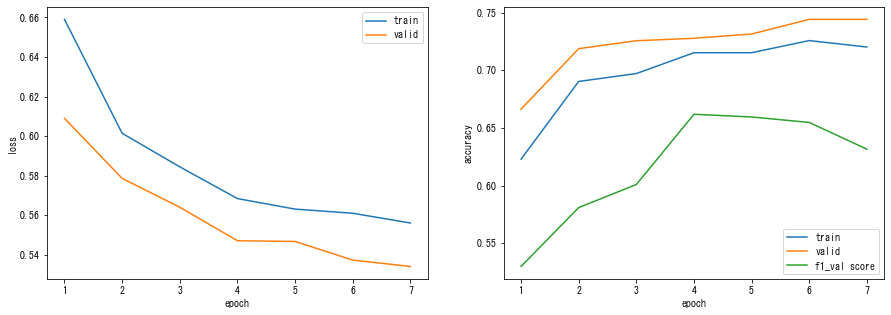

In [57]:
import matplotlib.pyplot as plt

x_axis = [x for x in range(1,epochs + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, history.history['loss'], label='train')
ax[0].plot(x_axis, history.history['val_loss'], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(x_axis, history.history['accuracy'], label='train')
ax[1].plot(x_axis, history.history['val_accuracy'], label='valid')
ax[1].plot(x_axis, np.array(f1cb.f1s), label="f1_val score")
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

# Create Submission

In [103]:
test_dataset = data['test'].map(
    tokenize_map_fn(tokenizer, max_length=max_length)
)
test_dataset = test_dataset.padded_batch(
    batch_size=1, 
    padded_shapes=(
        {'input_ids': max_length, 'token_type_ids': max_length, 'attention_mask': max_length},
        []
    ),
    drop_remainder=True
)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [104]:
pred = model.predict(test_dataset)

In [107]:
sample_submission = pd.read_csv("../data/input/sample_submission.csv")
sample_submission["target"] = np.where(pred>0.5, 1, 0)
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [108]:
import datetime
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [120]:
import pickle

sample_submission.to_csv("../data/output/sub_" + dt + "_BERT_finetune.csv", index=False)
model.save_weights("../models/model_" + dt + "_BERT_finetune_weights")
pickle.dump(history.history, open('../logs/train_score_' + dt + '.pickle', 'wb'))